In [1]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.stats import norm, halfnorm, uniform
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import bayesflow as beef
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from sklearn.metrics import r2_score

import sys
sys.path.append("../src/")
from priors import sample_mrw_eta, sample_mixture_random_walk
from likelihood import sample_softmax_rl
from context import generate_context
from configurator import configure_input
from helpers import softmax

/Users/lschumacher/miniconda3/envs/beef/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Suppress scientific notation for floats
np.set_printoptions(suppress=True)
# Configure rng
RNG = np.random.default_rng()

In [3]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# print(tf.config.list_physical_devices('GPU'))

In [4]:
TRAIN_NETWORK = False

In [5]:
LOCAL_PARAM_LABELS = ("Learning rate", "Sensitivity")
LOCAL_PARAM_NAMES = (r"$\alpha$", r"$\tau$")
GLOBAL_PARAM_LABELS = ("Standard deviation", "Standard deviation", "Switch probability")
GLOBAL_PARAM_NAMES = (r"$\sigma_{\alpha}$", r"$\sigma_{\tau}$", r"$\rho_{\alpha}$", r"$\rho_{\tau}$")

FONT_SIZE_1 = 22
FONT_SIZE_2 = 18
FONT_SIZE_3 = 16

GLOBAL_PRIOR_MEAN = np.concatenate(
    [
        halfnorm(0, [0.05, 3]).mean().round(decimals=2),
        uniform(0, [0.1, 0.1]).mean().round(decimals=2)
    ]
)
GLOBAL_PRIOR_STD = np.concatenate(
    [
        halfnorm(0, [0.05, 3]).std().round(decimals=2),
        uniform(0, [0.1, 0.1]).std().round(decimals=2)
    ]
)
LOCAL_PRIOR_MEAN = np.array([0.5, 37])
LOCAL_PRIOR_STD = np.array([0.3, 24])

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

## Read Empiric Data

In [6]:
emp_data = pd.read_csv("../data/data_fontanesi_prep.csv")
emp_data.f_cor = emp_data.f_cor / 60
emp_data.f_inc = emp_data.f_inc / 60

## Exemplar Trajectory

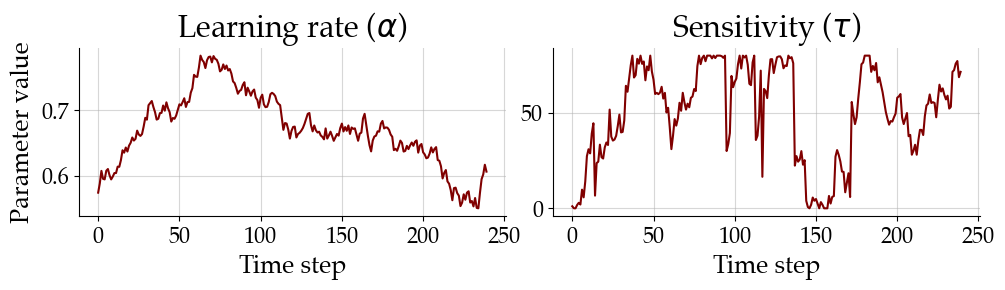

In [9]:
eta = sample_mrw_eta()
theta = sample_mixture_random_walk(eta)
time = np.arange(theta.shape[0])
fig, axarr = plt.subplots(1, 2, figsize=(10, 3))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        theta[:, i],
        color='maroon'
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} ({LOCAL_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()
# fig.savefig("../plots/exemplar_trajectory.pdf", dpi=300, bbox_inches="tight")

## Generative Model

### Prior

In [10]:
prior = beef.simulation.TwoLevelPrior(
    hyper_prior_fun=sample_mrw_eta,
    local_prior_fun=sample_mixture_random_walk,
)

### Context

In [11]:
context = beef.simulation.ContextGenerator(
    batchable_context_fun=generate_context,
)

### Likelihood

In [12]:
likelihood = beef.simulation.Simulator(
    simulator_fun=sample_softmax_rl,
    context_generator=context,
)

### Simulator

In [13]:
model = beef.simulation.TwoLevelGenerativeModel(
    prior=prior,
    simulator=likelihood,
    name="non-stationary_softmax_rl",
)

INFO:root:Performing 2 pilot runs with the non-stationary_softmax_rl model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 240, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 240)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 240, 2)
INFO:root:No shared_prior_draws provided.
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes care of that!
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


## Neural Approximator

In [14]:
approximator_settings = {
    "lstm1_hidden_units": 512,
    "lstm2_hidden_units": 256,
    "lstm3_hidden_units": 128,
    "trainer": {
        "max_to_keep": 1,
        "default_lr": 5e-4,
        "memory": False,
    },
    "local_amortizer_settings": {
        "num_coupling_layers": 8,
        "coupling_design": 'interleaved'
    },
    "global_amortizer_settings": {
        "num_coupling_layers": 6,
        "coupling_design": 'interleaved'
    },
}

In [15]:
summary_network = beef.networks.HierarchicalNetwork(
    [
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm1_hidden_units"], return_sequences=True)),
                Bidirectional(LSTM(approximator_settings["lstm2_hidden_units"], return_sequences=True)),
            ]
        ),
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm3_hidden_units"]))
            ]
        )
    ]
)

In [16]:
local_network = beef.amortizers.AmortizedPosterior(
    beef.networks.InvertibleNetwork(
        num_params=2,
        **approximator_settings.get("local_amortizer_settings")
    )
)
global_network = beef.amortizers.AmortizedPosterior(
    beef.networks.InvertibleNetwork(
        num_params=4,
        **approximator_settings.get("global_amortizer_settings")
    )
)

In [17]:
amortizer = beef.amortizers.TwoLevelAmortizedPosterior(
    local_amortizer=local_network,
    global_amortizer=global_network,
    summary_net=summary_network
)
trainer = beef.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configure_input,
    **approximator_settings.get("trainer"),
    checkpoint_path="../checkpoints/mrw__rl"
)

INFO:root:Loaded loss history from ../checkpoints/mrw__rl/history_200.pkl.
INFO:root:Networks loaded from ../checkpoints/mrw__rl/ckpt-200
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Training

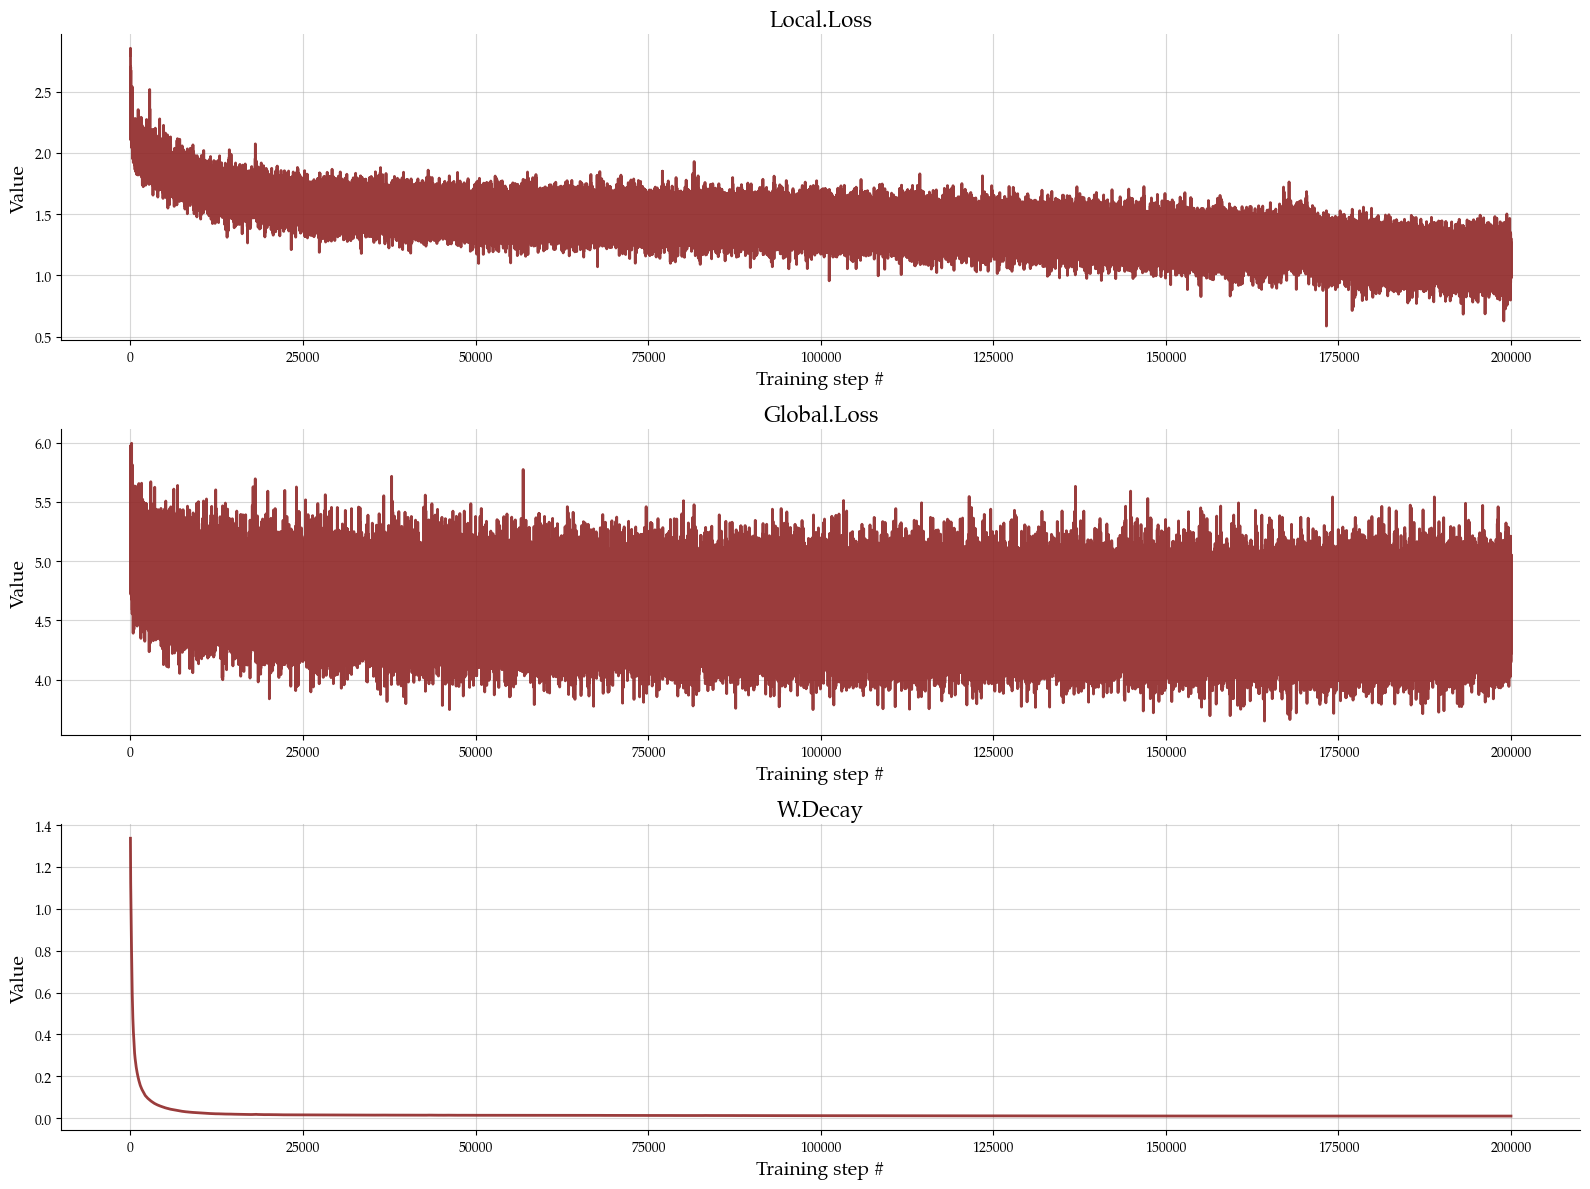

In [18]:
if TRAIN_NETWORK:
    history = trainer.train_online(
        epochs=200,
        iterations_per_epoch=1000,
        batch_size=32
    )
    loss_plot = beef.diagnostics.plot_losses(trainer.loss_history.get_plottable())
else:
    loss_plot = beef.diagnostics.plot_losses(trainer.loss_history.get_plottable())

## Validation

In [19]:
val_data = model(1)
theta_true = val_data['local_prior_draws'][0]
eta_true = val_data['hyper_prior_draws'][0]

In [20]:
val_data_config = configure_input(val_data)

In [21]:
post_sample = amortizer.sample(val_data_config, n_samples=1000)

### Local Parameters

In [22]:
theta_post = post_sample['local_samples'] * LOCAL_PRIOR_STD + LOCAL_PRIOR_MEAN
theta_post_mean = theta_post.mean(axis=1)
theta_post_std = theta_post.std(axis=1)

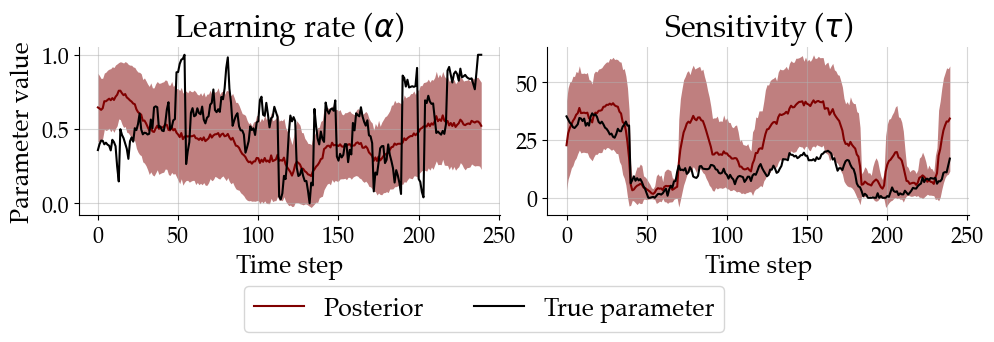

In [23]:
time = np.arange(theta_post_mean.shape[0])
fig, axarr = plt.subplots(1, 2, figsize=(10, 3))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        theta_post_mean[:, i],
        color='maroon', label="Posterior"
    )
    ax.plot(
        time,
        theta_true[:, i],
        color='black', label="True parameter"
    )
    ax.fill_between(
        time,
        theta_post_mean[:, i] - theta_post_std[:, i],
        theta_post_mean[:, i] + theta_post_std[:, i],
        color='maroon', alpha=0.5, linewidth=0.0
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} ({LOCAL_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
        fig.subplots_adjust(hspace=0.5)
        fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=2)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()
# fig.savefig("../plots/recovered_theta.pdf", dpi=300, bbox_inches="tight")

### Global Parameters

In [24]:
eta_post = post_sample['global_samples'] * GLOBAL_PRIOR_STD + GLOBAL_PRIOR_MEAN 

In [25]:
prior_samples = prior(1000)

In [26]:
prior_eta = prior_samples['hyper_parameters']

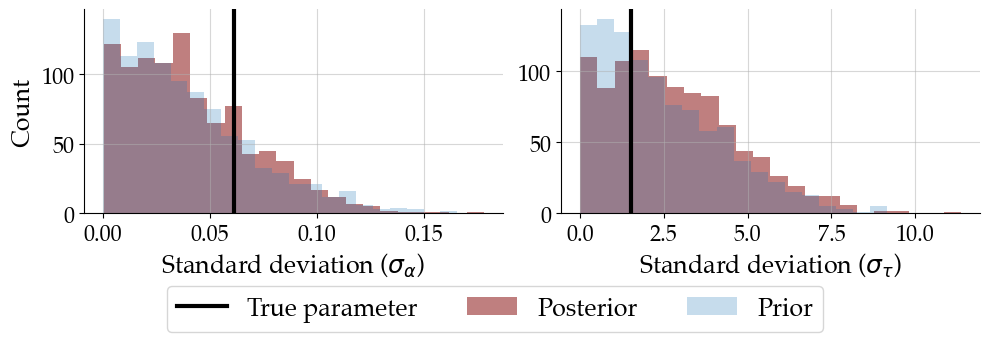

In [27]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 3))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.axvline(
        eta_true[i],
        color='black',
        lw=3,
        label="True parameter"
    )
    sns.histplot(
        eta_post[:, i],
        color='maroon',
        ax=ax,
        alpha=0.5,
        linewidth=0,
        label="Posterior"
    )

    sns.histplot(
        prior_eta[:, i],
        ax=ax,
        alpha=0.25,
        linewidth=0,
        label="Prior"
    )

    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_ylabel("", fontsize=FONT_SIZE_2)
    if i == 0:
        ax.set_ylabel("Count", fontsize=FONT_SIZE_2)
        fig.subplots_adjust(hspace=0.5)
        fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=3)
    ax.set_xlabel(f'{GLOBAL_PARAM_LABELS[i]} ({GLOBAL_PARAM_NAMES[i]})', fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()
# fig.savefig("../plots/recovered_eta.pdf", dpi=300, bbox_inches="tight")

## Fit to Empirical Data

In [ ]:
N_SAMPLES = 2000
# SUBJECTS = emp_data.id.unique()
RELEVANT_SUB = np.array([1, 3, 5, 6, 7, 8, 16, 20, 22, 23, 24, 26, 27])
theta_post = np.zeros((len(RELEVANT_SUB), 240, N_SAMPLES, 2))

In [ ]:
for i, sub in enumerate(tqdm(RELEVANT_SUB)):
    person_data = emp_data.loc[emp_data.id == sub][['resp', 'f_cor', 'f_inc', 'cor_option', 'inc_option']].to_numpy()
    resp = person_data[:, 0, None]
    feedback = person_data[:, 1:3]
    cor_option = person_data[:, 3, None]
    inc_option = person_data[:, 4, None]
    data = np.c_[
        resp, feedback, to_categorical(cor_option), to_categorical(inc_option)
    ]
    post_sample = amortizer.sample({'summary_conditions': data[None, :, :]}, n_samples=N_SAMPLES)
    theta_post[i] = post_sample['local_samples'] * LOCAL_PRIOR_STD + LOCAL_PRIOR_MEAN

In [ ]:
theta_post.shape

In [ ]:
post_means = np.mean(theta_post, axis=2)
post_std = np.std(theta_post, axis=2)
post_means_mean = np.mean(post_means, axis=0)
post_means_std = np.std(post_means, axis=0)

In [ ]:
time = np.arange(post_means_mean.shape[0])
fig, axarr = plt.subplots(1, 2, figsize=(12, 3.5))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        post_means_mean[:, i],
        color='maroon', label="Posterior"
    )
    ax.fill_between( 
        time,
        post_means_mean[:, i] - post_means_std[:, i],
        post_means_mean[:, i] + post_means_std[:, i],
        color='maroon', alpha=0.5, linewidth=0.0
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} ({LOCAL_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    xticks = np.arange(0, 240+1, 40)
    xticks[0] = 1
    ax.set_xticks(xticks)
    if i == 0:
        ax.set_yticks(np.arange(0, 0.7, 0.2))
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
        # fig.subplots_adjust(hspace=0.5)
        # fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=2)
    if i == 1:
        ax.set_yticks(np.arange(0, 51, 15))
    ax.set_xlabel("Trial", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()
fig.savefig("../plots/inferred_trajectories.pdf", dpi=300, bbox_inches="tight")

## Parameter Recovery

In [ ]:
NUM_SIM = 200
NUM_SAMPLES = 1000
TIME_POINTS = [39, 80, 120, 159]

In [ ]:
sim_data = model(NUM_SIM)
theta_true = sim_data['local_prior_draws']
eta_true = sim_data['hyper_prior_draws']
sim_data_config = trainer.configurator(sim_data)['summary_conditions']
sim_data_config.shape

In [ ]:
theta_post = np.zeros((NUM_SIM, 240, NUM_SAMPLES, 2))
eta_post = np.zeros((NUM_SIM, NUM_SAMPLES, 2))

In [ ]:
for i in tqdm(range(NUM_SIM)):
    post_samples = amortizer.sample({'summary_conditions': sim_data_config[i][None, :, :]}, n_samples=NUM_SAMPLES)
    theta_post[i] = post_samples['local_samples']
    eta_post[i] = post_samples['global_samples']

In [ ]:
# np.save('../data/local_post.npy', theta_post)
# np.save('../data/global_post.npy', eta_post)

In [ ]:
theta_post = theta_post * LOCAL_PRIOR_STD + LOCAL_PRIOR_MEAN
eta_post = eta_post * GLOBAL_PRIOR_STD + GLOBAL_PRIOR_MEAN 

In [ ]:
theta_post_mean = theta_post.mean(axis=2)

In [ ]:
theta_post_mean.shape

In [ ]:
theta_post_mean[TIME_POINTS[0], :, 0].shape

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(8, 16))

# create 4x1 subfigs
subfigs = fig.subfigures(nrows=4, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f"T = {TIME_POINTS[row] + 1}", fontsize=FONT_SIZE_1, fontweight='semibold')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        ax.scatter(
            theta_true[:, TIME_POINTS[row], col],
            theta_post_mean[:, TIME_POINTS[row], col],
            alpha=0.5, color="maroon"
            )
        
        # Make plots quadratic to avoid visual illusions
        lower = min(theta_true[:, TIME_POINTS[row], col].min(),
                    theta_post_mean[:, TIME_POINTS[row], col].min())
        upper = max(theta_true[:, TIME_POINTS[row], col].max(),
                    theta_post_mean[:, TIME_POINTS[row], col].max())
        eps = (upper - lower) * 0.1
        ax.set_xlim([lower - eps, upper + eps])
        ax.set_ylim([lower - eps, upper + eps])
        ax.plot(
            [ax.get_xlim()[0], ax.get_xlim()[1]],
            [ax.get_ylim()[0], ax.get_ylim()[1]],
            color="black",
            alpha=0.9,
            linestyle="dashed",
        )

        r2 = r2_score(
            theta_true[:, TIME_POINTS[row], col],
            theta_post_mean[:, TIME_POINTS[row], col]
        )
        ax.text(
            0.1, 0.9,
            "$R^2$ = {:.3f}".format(r2),
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            size=FONT_SIZE_3,
        )
        corr = np.corrcoef(
            theta_true[:, TIME_POINTS[row], col],
            theta_post_mean[:, TIME_POINTS[row], col]
        )[0, 1]
        ax.text(
            0.1, 0.8,
            "$r$ = {:.3f}".format(corr),
            horizontalalignment="left", 
            verticalalignment="center",
            transform=ax.transAxes,
            size=FONT_SIZE_3,
        )

        if row == 0:
            ax.set_title(LOCAL_PARAM_LABELS[col] + ' ({})'.format(LOCAL_PARAM_NAMES[col]), fontsize=FONT_SIZE_2)
        if row == 3:
            ax.set_xlabel("Ground truth", fontsize=FONT_SIZE_2)
        if col == 0:
            ax.set_ylabel("Estimated", fontsize=FONT_SIZE_2)
        #     ax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0])
        #     ax.set_yticks([0.0, 1.0, 2.0, 3.0, 4.0])
        #     if row > 1:
        #         ax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
        #         ax.set_yticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
        # if col == 1:
        #     ax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0])
        #     ax.set_yticks([0.0, 1.0, 2.0, 3.0, 4.0])
        # if col == 2:
        #     ax.set_xticks([0.0, 0.5, 1, 1.5])
        #     ax.set_yticks([0.0, 0.5, 1, 1.5])
        # Prettify
        ax.grid(alpha=0.5)
        ax.tick_params(axis="both", which="major", labelsize=FONT_SIZE_3)
        ax.tick_params(axis="both", which="minor", labelsize=FONT_SIZE_3)

sns.despine()
# fig.tight_layout()
plt.savefig('../plots/param_recovery.pdf', dpi=300, bbox_inches='tight')

## Posterior Re-simulation

In [ ]:
NUM_RESIM = 1000
BIN_IDX = np.arange(0, 240, 5)

In [ ]:
post_resim_data = np.zeros((len(RELEVANT_SUB), NUM_RESIM, 240, 2))

In [ ]:
for i, sub in enumerate(tqdm(RELEVANT_SUB)):
    person_data = emp_data.loc[emp_data.id == sub][['resp', 'f_cor', 'f_inc', 'cor_option', 'inc_option']].to_numpy()
    feedback = person_data[:, 1:3]
    cor_option = person_data[:, 3, None]
    inc_option = person_data[:, 4, None]
    context = np.c_[
        feedback, cor_option, inc_option
    ]

    idx = np.random.choice(np.arange(N_SAMPLES), size=NUM_RESIM, replace=False)
    for j in range(NUM_RESIM):
        current_params = theta_post[i, :, idx[j], :]
        post_resim_data[i, j, :, 0] = sample_softmax_rl(current_params, context)
        post_resim_data[i, j, :, 1] = (post_resim_data[i, j, :, 0] == cor_option[:, 0]).astype(int)

In [ ]:
pred_accuracy = np.zeros((NUM_RESIM, len(BIN_IDX), 1))
pred_accuracy.shape

In [ ]:
for i in range(NUM_RESIM):
    for l, bin in enumerate(bin_idx):
        pred_accuracy[i, l, 0] = post_resim_data[:, i, bin:bin+5, 1].mean()

In [ ]:
emp_correct = np.zeros((13, 240, 1))
for i, sub in enumerate(RELEVANT_SUB):
    emp_correct[i, :] =  emp_data.loc[emp_data.id == sub][['correct']].to_numpy()
emp_correct.shape

In [ ]:
for l, bin in enumerate(bin_idx):
    emp_accuracy[l, 0] = emp_correct[:, bin:bin+5].mean()

In [ ]:
mean_pred_acc = pred_accuracy.mean(axis=0)
std_pred_acc = pred_accuracy.std(axis=0)

In [ ]:
std_pred_acc

In [ ]:
trials[0::2]

In [ ]:
trials = np.arange(len(BIN_IDX))
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.grid(alpha=0.5)
ax.plot(
    trials,
    emp_accuracy,
    color='black', label="Empricial"
)
ax.plot(
    trials,
    mean_pred_acc,
    color='maroon', label="Re-simulated"
)
ax.fill_between( 
    trials,
    mean_pred_acc[:, 0] - std_pred_acc[:, 0],
    mean_pred_acc[:, 0] + std_pred_acc[:, 0],
    color='maroon', alpha=0.5, linewidth=0.0
)

ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3+1)
ax.set_xticks(trials[0::4], labels=BIN_IDX[0::4])
ax.set_ylabel("Accuracy", fontsize=FONT_SIZE_2+4, labelpad=10)
fig.subplots_adjust(hspace=0.5)
fig.legend(fontsize=FONT_SIZE_2+4, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=2)
ax.set_xlabel("Trial", fontsize=FONT_SIZE_2+4, labelpad=10)

sns.despine()
fig.tight_layout()
fig.savefig("../plots/post_resim_accuracy_bin.pdf", dpi=300, bbox_inches="tight")